# Classify
* Load the feature matrix prepared in previous notebook
* Compute a baseline
* Load pre-trained model MobileNetV3Small
* Fit the classifier including the pre-trained model and a dense network
* Save the fitted classifier

In [1]:
import numpy as np
from os.path import join
from sklearn.dummy import DummyClassifier
import pickle
import pandas as pd
import random
import time

import tensorflow as tf
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, RandomBrightness
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical

from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

2025-02-19 20:29:42.938573: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-19 20:29:42.947488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739993382.957155   43529 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739993382.959823   43529 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 20:29:42.969905: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Global variables

In [2]:
DATA_PATH = 'data'
MODELS_PATH = 'models'

In [3]:
# input image dimensions
input_width = 300
input_height = 300
input_depth = 3
input_dim = input_width*input_height*input_depth
input_shape = (input_width, input_height, input_depth)

# classification classes
output_classes = 3

# define results matrix
eval_pd = pd.DataFrame(columns=['model', 'accuracy', 'CPU_time'])

Load the feature matrix prepared in previous notebook

In [4]:
with np.load(join(DATA_PATH, 'train_data.npz')) as data:
    data_dict=dict(data.items())
X = data_dict['X']
y = data_dict['y']

## Compute a baseline

In [5]:
# Create the dummy classifier
dummy = DummyClassifier(strategy='most_frequent')

# Fit it to the train data
dummy.fit(X, y)
accuracy = dummy.score(X, y)
eval_pd.loc[len(eval_pd)] = {'model': 'dummy' , 'accuracy': accuracy, 'CPU_time': None}
print(f"The baseline accuracy is {accuracy:0.2f}")

The baseline accuracy is 0.46


## Classify using transfer learning
* Load pre-trained model MobileNetV3Small
* Fit the classifier including the pre-trained model and a dense network

In [6]:
# one-hot encode the labels
classes, y_classes = np.unique(y, return_inverse=True)
y = to_categorical(y_classes, num_classes=output_classes)

Display some images for checking

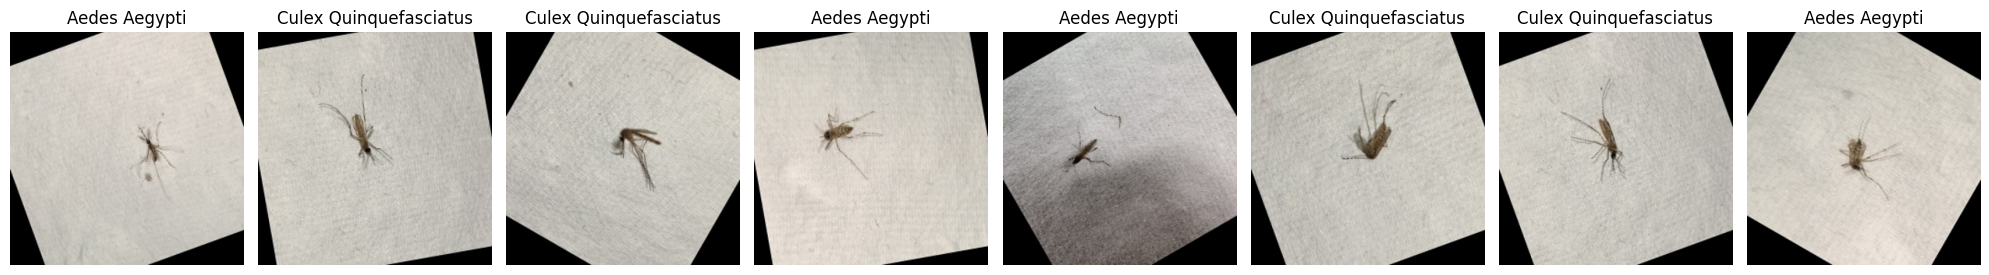

In [7]:
check_images = 8
idx = random.sample(range(len(X)-1), check_images)
fig, ax = plt.subplots(1, check_images, figsize=(20, 10))
for i, id in enumerate(idx):
    data = X[id].astype('uint8')
    img = Image.fromarray(data, 'RGB')
    ax[i].imshow(img)
    class_name = classes[list(y[id]).index(1)]
    ax[i].set_title(class_name)
    ax[i].axis('off')
plt.tight_layout()
plt.show();

Load pre-trained model

In [8]:
backbone = tf.keras.applications.MobileNetV3Small(
    input_shape=input_shape,
    alpha=1.0,
    minimalistic=True,
    include_top=False,
    weights='imagenet',
    dropout_rate=0.2,
    include_preprocessing=True
)
backbone.trainable = False

/home/atroncos/workspace/oa_venv/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(
2025-02-19 20:29:45.736460: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Define the local model

In [9]:
input = Input(shape=(input_width, input_height, input_depth))

x = backbone(input, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)

output = Dense(output_classes, activation='softmax')(x)

model = Model(input, output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 10, 10, 576)    │       441,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,167,531 (4.45 MB)

 Trainable params: 724,483 (2.76 MB)

 Non-trainable params: 443,048 (1.69 MB)

In [10]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name='accuracy')]
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = loss_function,
    metrics = metrics
)

Fit the model

In [11]:
%%time

callback = EarlyStopping(monitor='val_accuracy', patience=5)
# Fit model
history = model.fit(
    x=X, y=y,
    validation_split=0.2,
    batch_size=32, epochs=20,
    callbacks=[callback]
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 241ms/step - accuracy: 0.7610 - loss: 0.5915 - val_accuracy: 0.8131 - val_loss: 0.5092
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - accuracy: 0.9760 - loss: 0.0671 - val_accuracy: 0.9343 - val_loss: 0.3404
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - accuracy: 0.9937 - loss: 0.0264 - val_accuracy: 0.9268 - val_loss: 0.2467
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.9949 - loss: 0.0140 - val_accuracy: 0.9091 - val_loss: 0.2385
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.9841 - loss: 0.0521 - val_accuracy: 0.9722 - val_loss: 0.1141
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.9816 - loss: 0.0586 - val_accuracy: 0.9747 - val_loss: 0.0630
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.9942 - loss: 0.0171 - val_accuracy: 0.9520 - val_loss: 0.1380
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.9888 - loss: 0.0328 - val_accu

Display validation loss and accuracy

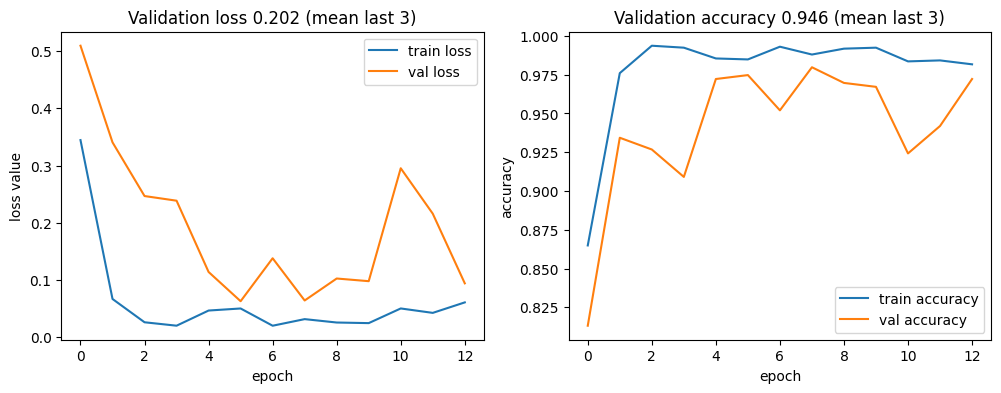

In [12]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='val accuracy')
ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_accuracy'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()

Save the model

In [13]:
with open(join(MODELS_PATH, 'transfer_mobilenet.pickle'), 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Evaluate

In [14]:
# Load the data prepared in previous notebook
with np.load(join(DATA_PATH, 'test_data.npz')) as data:
    data_dict=dict(data.items())
X_test = data_dict['X']
y_test = data_dict['y']

In [15]:
# One-hot encode the labels
classes_test, y_test_classes = np.unique(y_test, return_inverse=True)
y_test = to_categorical(y_test_classes, num_classes=output_classes)    

In [16]:
%%time

# number of times the accuracy tests should be repeated
NUM_TESTS = 10

model_name = 'transfer'
for _ in range(NUM_TESTS):

    start = time.process_time()
    # Compute accuracy on the test set
    (_, accuracy) = model.evaluate(X_test, y_test, batch_size=32)
    dtime = time.process_time() - start
    
    eval_pd.loc[len(eval_pd)] = {'model': model_name , 'accuracy': accuracy, 'CPU_time': dtime}

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.9802 - loss: 0.0453


<timed exec>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.9802 - loss: 0.0453
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.9802 - loss: 0.0453
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.9802 - loss: 0.0453
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.9802 - loss: 0.0453
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.9802 - loss: 0.0453
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.9802 - loss: 0.0453
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.9802 - loss: 0.0453
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.9802 - loss: 0.0453
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.9802 - loss: 0.0453
CPU times: user 4min 34s, sys: 6.89 s, total: 4min 41s
Wall time: 37.3 s


Averages per sample

In [17]:
avg_df = pd.DataFrame(columns=['model', 'average accuracy', 'average time'])
def get_eval_avg(model):
    acc_avg = eval_pd[eval_pd.model==model].accuracy.mean()
    time_avg = eval_pd[eval_pd.model==model].CPU_time.mean()/X_test.shape[0]
    return acc_avg, time_avg
acc_avg, time_avg = get_eval_avg('dummy')
avg_df.loc[len(avg_df)] = {'model': 'Dummy' , 'average accuracy': acc_avg, 'average time': time_avg}
#acc_avg, time_avg = get_eval_avg('svn')
#avg_df.loc[len(avg_df)] = {'model': 'Support Vector Machine' , 'average accuracy': acc_avg, 'average time': time_avg}
acc_avg, time_avg = get_eval_avg('transfer')
avg_df.loc[len(avg_df)] = {'model': 'Transfer MobileNet' , 'average accuracy': acc_avg, 'average time': time_avg}

In [18]:
avg_df

,model,average accuracy,average time
0,Dummy,0.459596,NaN
1,Transfer MobileNet,0.978788,0.04261
